## Context
Simulations contain an ideal electrolyte at approximately 1M in a slit-pore geometry of width 5 nm.

Simulations are periodic in both x- and y-directions.

I'm interested in calculating the effect that confinement has on the current flux normal to the slit-pore geometry. i.e. in the z-direction. Ultimately, we want to attain the complex conductivity spectra of the system.

J_z = current density of a ideal electrolyte in the z-direction.

There are 50 seperate replicate simulations.

### Workflow
1. Extract J_z from the simulations.
2. Find the correlation function of J_z.
3. Take the fourier transform of the correlation function. This fourier transform relates to a complex conductivity spectra.

### Folder layout

- J_z : data folder
   - replica_n : data for each replicated simulation
     - J_corr :  
       - J_z.npy : numpy vector containing J_z data
       - J_corr_z.npy : numpy vector containing the correlation function of J_z


In [1]:
# Import relevant packages
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Number of replicas that have been simulated...
n_replicas = 50

In [3]:
# Each simulation has been run for 1 microsecond.
# Data is saved every 500 fs.
# There are 2000001 datasteps in each J_z.npy and J_corr_z.npy

dt = 500e-15 # fs
n_datasteps = 2000001

time = np.arange(0, n_datasteps) * dt

### Example correlation function

Text(0, 0.5, '$\\langle$J$_z$.J$_z\\rangle$')

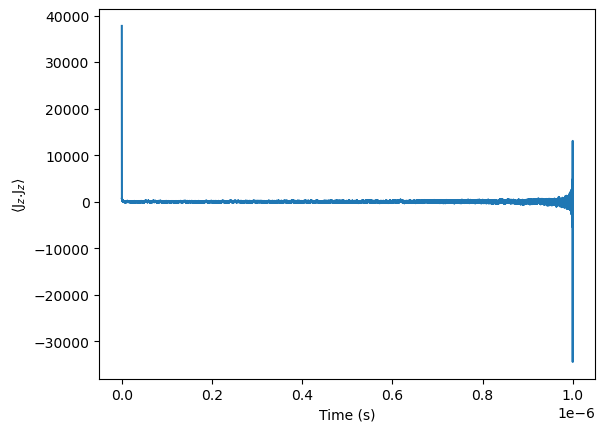

In [4]:
example_correlation_fn = np.load('J_z/replica_01/J_corr/J_corr_z.npy')

plt.plot(time, example_correlation_fn)
plt.xlabel('Time (s)')
plt.ylabel(r'$\langle$J$_z$.J$_z\rangle$')

### Zoomed in example correlation function

The correlation function presents two key features:
1. A fast decay, caused by ions bouncing off one another - timescale ~ ps.
2. An exponential decay caused by ions bouncing between walls in the slit pore ~ ns.

Beyond ~ 10 ns noise tends to dominate the signal.

Text(0, 0.5, '$\\langle$J$_z$.J$_z\\rangle$')

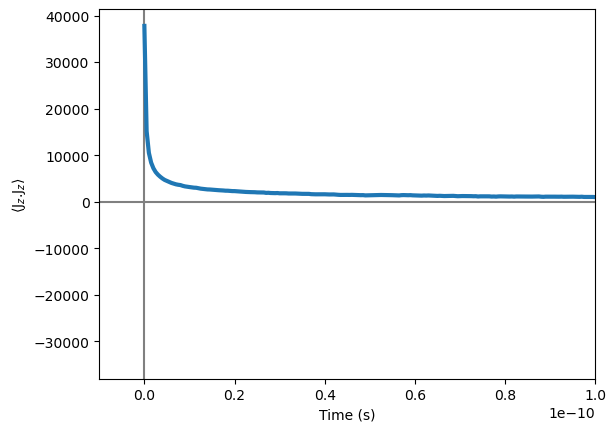

In [5]:
example_correlation_fn = np.load('J_z/replica_01/J_corr/J_corr_z.npy')

plt.plot(time, example_correlation_fn, lw=3)
plt.xlim(-1e-11, 1e-10)
plt.axvline(0, color='grey', zorder=-1)
plt.axhline(0, color='grey', zorder=-1)

plt.xlabel('Time (s)')
plt.ylabel(r'$\langle$J$_z$.J$_z\rangle$')

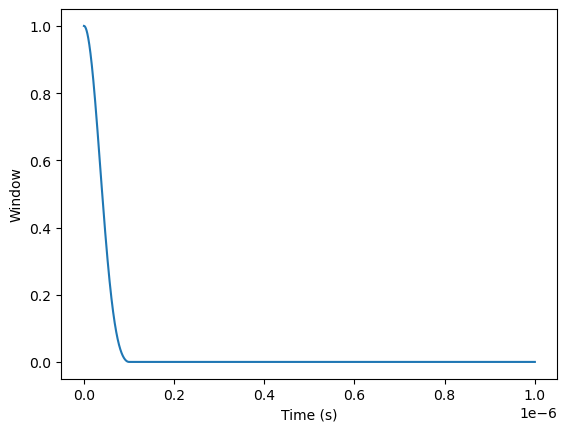

In [6]:
# Create a windowing function.
# This helps reduce noise in the long-time tail of the correlation function.
# By making the window at least half the size of the correlation function, we also solve issues related to zero-padding.

# The interesting physics should happen within a few nanoseconds, so our window function only need be small here.

from scipy.signal.windows import hann, hamming, blackman

# Create a window function of length 100 ns
# NB, we only save the positive time values of the correlation function,
# We therefore only want the half window.
# For the fourier transform of J_z, we're only interested in the positive frequency components.

# 2 * 100 ns = 200e-9 s
# NB Factor of 2, as we'll take the half window
window_length = int(200e-9 / 500e-15) + 1
full_window = blackman(window_length)
half_window = full_window[window_length//2:]

# Generate the window function
window = np.zeros_like(time)
window[:len(half_window)] += half_window

# Plot the window
plt.xlabel('Time (s)')
plt.ylabel('Window')
plt.plot(time, window)

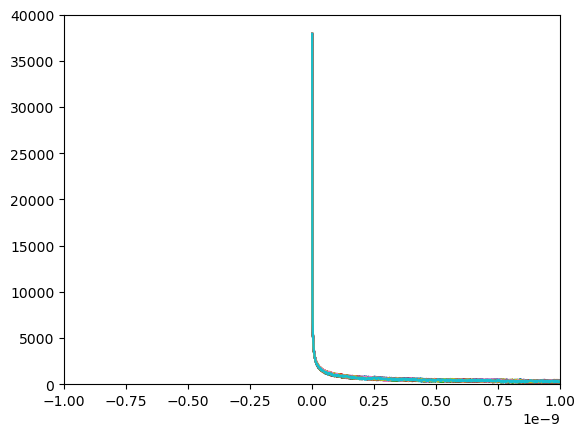

In [7]:
import scipy.fft

# Create empty array for fourier transforms
# NB: the fourier transforms are going to be complex
fourier_transforms = np.full((n_replicas, 1000001), np.nan).astype(complex) 

# Load up the correlation data
# Multiply each correlation function by the half window.
# Calculate the fourier transform of each (J_z * window)

for i in range(n_replicas):
    # Load up the correlation
    correlation_fn = np.load(f"J_z/replica_{i+1:02d}/J_corr/J_corr_z.npy")
    plt.plot(time, correlation_fn)

    # Apply the window function
    correlation_fn *= window

    # Take the fourier transform
    ft = scipy.fft.rfft(correlation_fn * window) * dt

    # Save the fourier transform
    fourier_transforms[i] = ft
plt.xlim(-1e-9,1e-9)
plt.ylim(0,40000)
plt.ylim
plt.show()

In [10]:
from scipy import stats

# Confidence intervals of 95%
confidence_level = 0.95
alpha = 1 - confidence_level
t_critical = stats.t.ppf(1 - alpha/2, df=n_replicas-1)

# Confidence intervals for real component
real_mean = np.mean(fourier_transforms.real, axis=0)
real_std = np.std(fourier_transforms.real, axis=0, ddof=1)
margin_of_error = t_critical * (real_std / np.sqrt(n_replicas))
real_ci_upper = real_mean + margin_of_error
real_ci_lower = real_mean - margin_of_error

# Confidence intervals for imaginary component
imag_mean = np.mean(fourier_transforms.imag, axis=0)
imag_std = np.std(fourier_transforms.imag, axis=0, ddof=1)
margin_of_error = t_critical * (imag_std / np.sqrt(n_replicas))
imag_ci_upper = imag_mean + margin_of_error
imag_ci_lower = imag_mean - margin_of_error

In [11]:
# Define frequencies

n_fft = len(window)
freqs = scipy.fft.rfftfreq(n_fft, d=dt)

(1000000.0, 1000000000000.0)

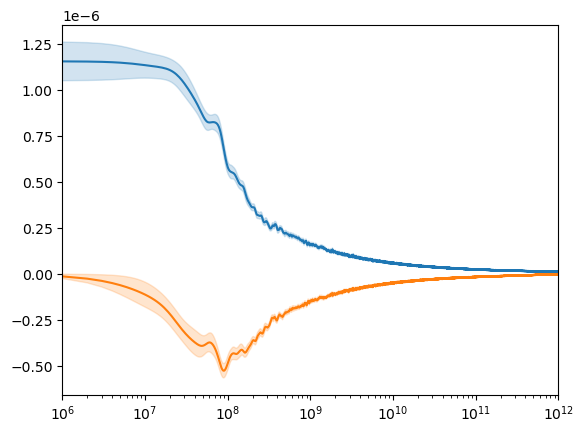

In [12]:
# Plot the fourier transforms

plt.plot(freqs,  real_mean)
plt.fill_between(freqs, real_ci_lower, real_ci_upper, color='C0', alpha=0.2, label='Confidence Interval')

plt.plot(freqs, imag_mean)
plt.fill_between(freqs, imag_ci_lower, imag_ci_upper, color='C1', alpha=0.2, label='Confidence Interval')

plt.xscale('log')
plt.xlim(1e6, 1e12)